# Multi-label Disease Classification of Chest X-Ray Images

UC San Diego Machine Learning Engineering Bootcamp

Tung Nguyen

## Introduction

Dataset: NIH Chest X-Rays from Kaggle, https://www.kaggle.com/nih-chest-xrays/data

This notebook contains trade studies performed with the InceptionV3 and DenseNet models

## Imports
---

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from skmultilearn.model_selection.iterative_stratification import iterative_train_test_split

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_input_inception

from tensorflow.keras.applications import DenseNet169, DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_input_densenet

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from sklearn.metrics import roc_curve, auc, precision_recall_curve, multilabel_confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
random_state = 2022

train_size = 0.8
val_size = 0.2
test_size = 0.25

In [3]:
data_dir = '/Users/tungnguyen/Documents/capstone/data/'

## Data Preprocessing
---

### Wrangling

In [4]:
# Read CSV
df = pd.read_csv('/Users/tungnguyen/Documents/capstone/Data_Entry_2017.csv')

# Drop unnecessary columns
df.drop(['OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'], axis=1, inplace=True)
print('Original DataFrame shape = {}'.format(df.shape))

# Some patients have age >200 - impute with mean of age from rows with the same Patient ID
err = df[df['Patient Age'] > 100]
df_dropped = df[df['Patient Age'] < 100]

for ind, row in err.iterrows():
    pid = row['Patient ID']
    avg = df_dropped[df_dropped['Patient ID'] == pid]['Patient Age'].mean()
    df.iat[ind, 4] = int(avg) if not(np.isnan(avg)) else -1

# There are ~3 patients with just a single datapoint - drop these 3 data points
df = df[df['Patient Age'] != -1]
df.reset_index(inplace=True)
print('Wrangled DataFrame shape = {}'.format(df.shape))

# Replace "No Finding" labels with blank
df['Finding Labels'] = df['Finding Labels'].replace(to_replace='No Finding', value='')

# Binarize
mlb = MultiLabelBinarizer()
lbl = mlb.fit_transform(df['Finding Labels'].str.split("|"))
df_mlb = pd.DataFrame(lbl, columns=mlb.classes_, dtype=np.float32)

# Drop 'No Finding' column
df_mlb.drop('', axis=1, inplace=True)

# Merge with main df
df = df.join(df_mlb)
print('Binarized DataFrame shape = {}'.format(df.shape))

# Get list of all labels
labels = [x for x in mlb.classes_ if x != '']
print()
print(labels)

Original DataFrame shape = (112120, 7)
Wrangled DataFrame shape = (112117, 8)
Binarized DataFrame shape = (112117, 22)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


### Splitting

In [5]:
tab_data_cols = ['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position']
X = df[tab_data_cols]
y = df[labels]

X_train, y_train, X_test, y_test = iterative_train_test_split(
    X.to_numpy(), 
    y.to_numpy(), 
    test_size=test_size,
)

In [6]:
# Convert matrices to DataFrames for Keras' flow_from_dataframe
train_df = pd.DataFrame(
    np.hstack((X_train, y_train)),
    columns=[item for sublist in [tab_data_cols, labels] for item in sublist]
)

test_df = pd.DataFrame(
    np.hstack((X_test, y_test)),
    columns=[item for sublist in [tab_data_cols, labels] for item in sublist]
)

# Convert labels to float32 for Keras training
for col in train_df:
    if col in labels:
        train_df[col] = train_df[col].astype(np.float32)
        
for col in test_df:
    if col in labels:
        test_df[col] = test_df[col].astype(np.float32)

### Sampling

In [7]:
plt.style.use('tableau-colorblind10')

In [8]:
def plot_df_freq(df, labels, offset=500, title='Frequency of Positive Labels'):
    df_pos = df[labels].sum()

    ax = df_pos.plot(kind='bar', figsize=(15, 7), rot=20);
    ax.set_title(title);
    ax.set_xlabel('Labels');
    ax.set_ylabel('Frequency');

    for i, val in enumerate(df_pos.values):
        ax.text(i, val + offset, int(val), ha = 'center')
        
    return df_pos

In [9]:
weights = []
for i, lbl in enumerate(labels):
    weights.append(dict(enumerate(compute_class_weight(class_weight='balanced', classes=[0., 1.], y=train_df[lbl]))))

# Normalized class weights for weighted loss
pos = np.array([])
neg = np.array([])
for d in weights:
    pos = np.append(pos, d[1] / sum(d.values()))
    neg = np.append(neg, d[0] / sum(d.values())) 
    
# Non-normalized class weights for weighted loss
pos_2 = np.array([])
neg_2 = np.array([])
for d in weights:
    pos_2 = np.append(pos_2, d[1])
    neg_2 = np.append(neg_2, d[0])

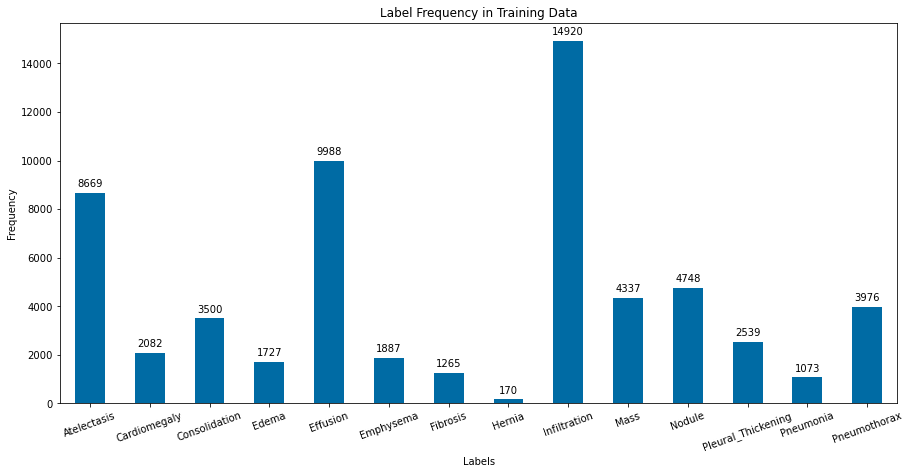

In [10]:
df_freq = plot_df_freq(train_df, labels, offset=250, title='Label Frequency in Training Data')

Atelectasis           5198.0
Cardiomegaly          1697.0
Consolidation         2778.0
Edema                 1512.0
Effusion              6440.0
Emphysema             1617.0
Fibrosis              1111.0
Hernia                 170.0
Infiltration          6873.0
Mass                  3067.0
Nodule                3042.0
Pleural_Thickening    2052.0
Pneumonia             1007.0
Pneumothorax          2780.0
dtype: float32

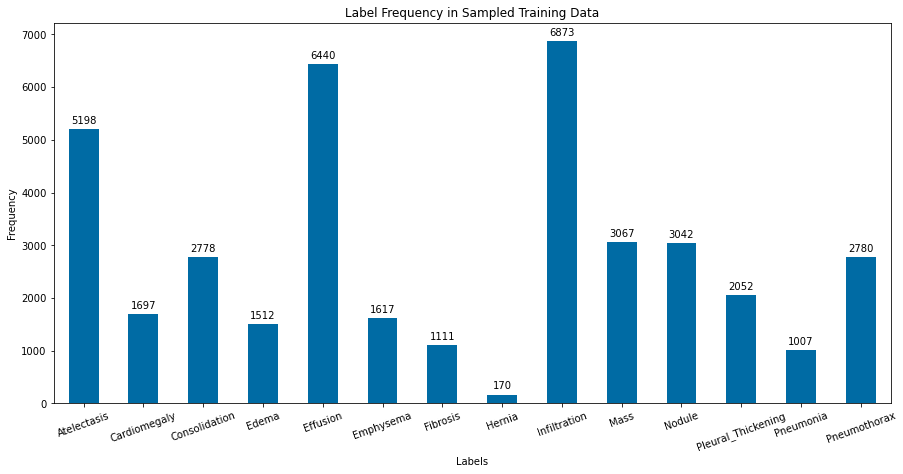

In [11]:
sample_weights = compute_sample_weight(class_weight=weights, y=train_df[labels])
train_df['sample_weights'] = sample_weights

sampled_train_df = train_df.sample(
    20000, 
    weights=sample_weights,
    random_state=random_state
)

plot_df_freq(sampled_train_df, labels, offset=100, title='Label Frequency in Sampled Training Data')

Atelectasis           1480.0
Cardiomegaly           281.0
Consolidation          704.0
Edema                  531.0
Effusion              1870.0
Emphysema             1746.0
Fibrosis              1705.0
Hernia                  23.0
Infiltration          3704.0
Mass                  2361.0
Nodule                2335.0
Pleural_Thickening    2052.0
Pneumonia             1656.0
Pneumothorax           962.0
dtype: float32

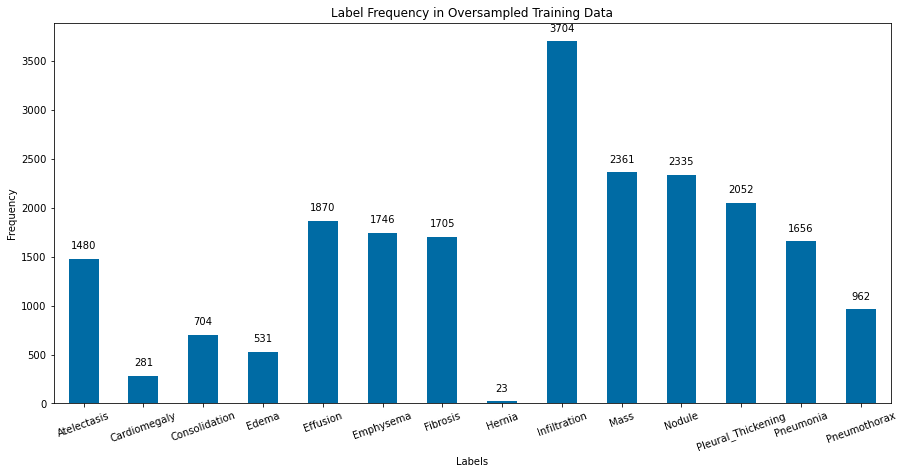

In [12]:
oversampled_train_df = pd.DataFrame([])

n = 1500

# Labels with lowest AUC from Model 6
low_auc_labels = ['Pneumonia', 'Nodule', 'Mass', 'Pleural_Thickening', 'Fibrosis', 'Infiltration', 'Emphysema']

# Sample each label
for lbl in low_auc_labels:
    temp = train_df[train_df[lbl] == 1].sample(
        n,
        replace=True,
        random_state=random_state
    )
    
    oversampled_train_df = pd.concat([oversampled_train_df, temp])
    
# Sample null label
temp = train_df[train_df['Finding Labels'] == ''].sample(
    n,
    replace=False,
    random_state=random_state
)
oversampled_train_df = pd.concat([oversampled_train_df, temp])

plot_df_freq(oversampled_train_df, labels, offset=100, title='Label Frequency in Oversampled Training Data')

In [13]:
def get_weighted_loss(pos, neg, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        loss = 0.0
        for i in range(len(pos)):
            loss += -1 * K.mean(pos * y_true * K.log(y_pred + epsilon) + 
                          (1 - y_true) * neg * K.log(1 - y_pred + epsilon))      
        return loss
    return weighted_loss

### Helper Functions

In [14]:
def plot_losses(model_history, figsize=(15, 10)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(model_history.history['val_loss'], 'r-o')
    ax.plot(model_history.history['loss'], 'b-o')
    ax.set_title('Training vs. Validation Loss')
    ax.legend(['Validation Loss', 'Training Loss'])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

def plot_roc_auc(y_pred, test_df, labels, model_name, figsize=(15, 10)):
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, lbl in enumerate(labels):
        fpr, tpr, thresholds = roc_curve(test_df[lbl].to_numpy(), y_pred[:, i])
        ax.plot(fpr, tpr, label = '%s (AUC: %0.2f)'  % (lbl, auc(fpr, tpr)))
        print("AUC = %0.4f for %s" % (auc(fpr, tpr), lbl))

    ax.legend()
    ax.set_title('ROC Curves for Test Data - ' + model_name);
    ax.set_xlabel('False Positive Rate (FPR)');
    ax.set_ylabel('True Positive Rate (TPR)');

def plot_precision_recall_auc(y_pred, test_df, labels, model_name, figsize=(15, 10)):
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, lbl in enumerate(labels):
        pr, rc, thresholds = precision_recall_curve(test_df[lbl].to_numpy(), y_pred[:, i])
        ax.plot(rc, pr, label = '%s (AUC: %0.4f)'  % (lbl, auc(rc, pr)))
        print("AUC = %0.4f for %s" % (auc(rc, pr), lbl))

    ax.legend()
    ax.set_title('Precision-Recall Curves for Test Data - ' + model_name);
    ax.set_xlabel('Recall');
    ax.set_ylabel('Precision');

In [15]:
def datagen_from_df(train_df, test_df, x_col, y_cols, data_path, preproc_func=None,
                    target_size=(256, 256), val_split=0.2, batch_size=64, sample_size=1000, color_mode='rgb', 
                    sample_center=False, sample_std=False, feature_center=False, feature_std=False, rescale_factor=None, 
                    weight_col=None, random_state=2022):

    datagen = ImageDataGenerator(
        preprocessing_function=preproc_func,
        validation_split=val_split,
        samplewise_center=sample_center,
        samplewise_std_normalization=sample_std,
        featurewise_center=feature_center,
        featurewise_std_normalization=feature_std,
        rescale=rescale_factor,
        horizontal_flip = True, 
        vertical_flip = False, 
        height_shift_range= 0.05, 
        width_shift_range=0.1, 
        rotation_range=5, 
        shear_range = 0.1,
        fill_mode = 'reflect',
        zoom_range=0.15,
    )

    if feature_center or feature_std:
        raw_train_generator = ImageDataGenerator().flow_from_dataframe(
            train_df,   
            data_path,
            shuffle=True,
            batch_size=sample_size,
            class_mode='raw',
            color_mode=color_mode,
            target_size=target_size,
            x_col=x_col,
            y_col=y_cols,
            seed=random_state
        )

        first_batch = raw_train_generator.next()
        data_sample = first_batch[0]
        datagen.fit(data_sample, augment=False, rounds=1, seed=random_state)

    train_generator = datagen.flow_from_dataframe(
        train_df,   
        data_path,
        shuffle=True,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        weight_col=weight_col,
        subset='training',
        seed=random_state
    )

    validation_generator = datagen.flow_from_dataframe(
        train_df,
        data_path,
        shuffle=False,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        subset='validation',
        seed=random_state
    )

    test_generator = datagen.flow_from_dataframe(
        test_df,
        data_path,
        shuffle=False,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        seed=random_state
    )
    
    return train_generator, validation_generator, test_generator

In [16]:
# Callbacks
early = EarlyStopping(
    monitor="val_loss",
    mode="min", 
    patience=8
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=4, 
    min_lr=0.001
)

## Additional Trade Studies
---

### DataGenerators

In [17]:
train_generator_64, valid_generator_64, test_generator_64 = datagen_from_df(
    oversampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=preprocess_input,
    target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', 
    sample_center=False, sample_std=False, feature_center=False, feature_std=False,
    weight_col=None, rescale_factor=None
)

Found 9600 validated image filenames.
Found 2400 validated image filenames.
Found 28030 validated image filenames.


In [18]:
train_generator_12, valid_generator_12, test_generator_12 = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=preprocess_input_inception,
    target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', 
    sample_center=False, sample_std=False, feature_center=False, feature_std=False,
    weight_col=None, rescale_factor=None
)

Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


In [19]:
train_generator_131, valid_generator_131, test_generator_131 = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=preprocess_input_densenet,
    target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', 
    sample_center=False, sample_std=False, feature_center=False, feature_std=False,
    weight_col=None, rescale_factor=None
)

Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


In [20]:
train_generator_132, valid_generator_132, test_generator_132 = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=preprocess_input_densenet,
    target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', 
    sample_center=False, sample_std=False, feature_center=False, feature_std=False,
    weight_col=None, rescale_factor=None
)

Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


### Model 6.4
Continue training on labels with worst AUC from Model 6

In [21]:
# Base Model
base_model = VGG16(
    include_top=False,
    weights=None,
    input_shape=(256, 256, 3)
)

model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = True
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))

model.load_weights('/Users/tungnguyen/Documents/repos/mec-capstone/Round1/vgg16-model-6.h5')

#model.summary()

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-02-05 12:55:18.814678: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-05 12:55:18.814845: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [22]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg)
)

In [23]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/Round4/vgg16-model-6-4.h5'

chkpt_64 = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [24]:
%%time
history_64 = model.fit(
    train_generator_64, 
    validation_data=valid_generator_64,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_64, early, reduce_lr]
)

2022-02-05 12:55:20.079804: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/40


2022-02-05 12:55:20.592774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


150/150 [==============================] - ETA: 0s - loss: 1.0851

2022-02-05 12:59:06.223239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.47185, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round4/vgg16-model-6-4.h5
150/150 [==============================] - 265s 2s/step - loss: 1.0851 - val_loss: 1.4719 - lr: 0.0010
Epoch 2/40
150/150 [==============================] - ETA: 0s - loss: 1.0714
Epoch 00002: val_loss did not improve from 1.47185
150/150 [==============================] - 262s 2s/step - loss: 1.0714 - val_loss: 1.5235 - lr: 0.0010
Epoch 3/40
150/150 [==============================] - ETA: 0s - loss: 1.0615
Epoch 00003: val_loss did not improve from 1.47185
150/150 [==============================] - 262s 2s/step - loss: 1.0615 - val_loss: 1.6153 - lr: 0.0010
Epoch 4/40
150/150 [==============================] - ETA: 0s - loss: 1.0618
Epoch 00004: val_loss did not improve from 1.47185
150/150 [==============================] - 262s 2s/step - loss: 1.0618 - val_loss: 1.4993 - lr: 0.0010
Epoch 5/40
150/150 [==============================] - ETA: 0s 

In [25]:
y_pred_64 = model.predict(test_generator_64, batch_size=64, verbose=True)

2022-02-05 13:34:44.875548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 455s 1s/step


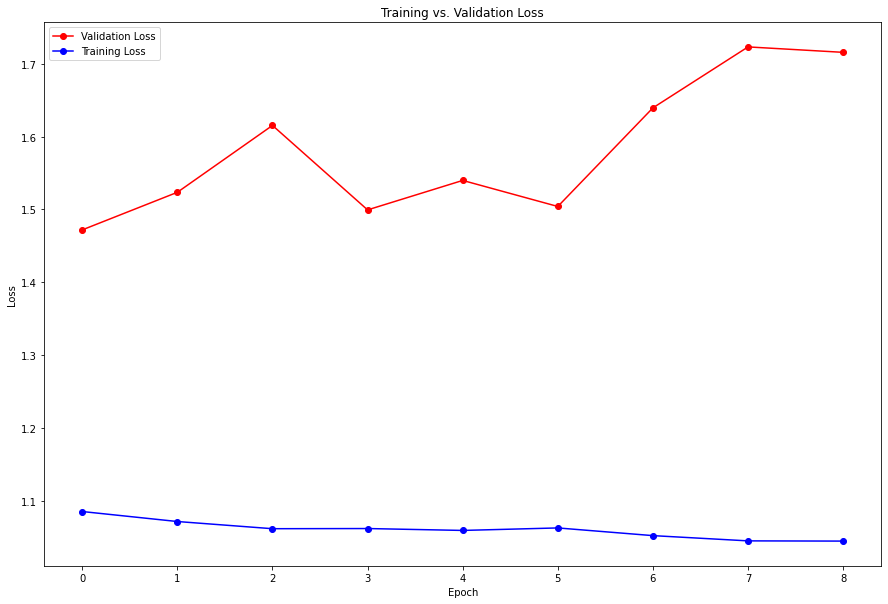

In [26]:
plot_losses(history_64)

AUC = 0.7082 for Atelectasis
AUC = 0.8211 for Cardiomegaly
AUC = 0.7223 for Consolidation
AUC = 0.8442 for Edema
AUC = 0.7883 for Effusion
AUC = 0.6697 for Emphysema
AUC = 0.6125 for Fibrosis
AUC = 0.5939 for Hernia
AUC = 0.6227 for Infiltration
AUC = 0.6468 for Mass
AUC = 0.5735 for Nodule
AUC = 0.6438 for Pleural_Thickening
AUC = 0.6332 for Pneumonia
AUC = 0.6745 for Pneumothorax


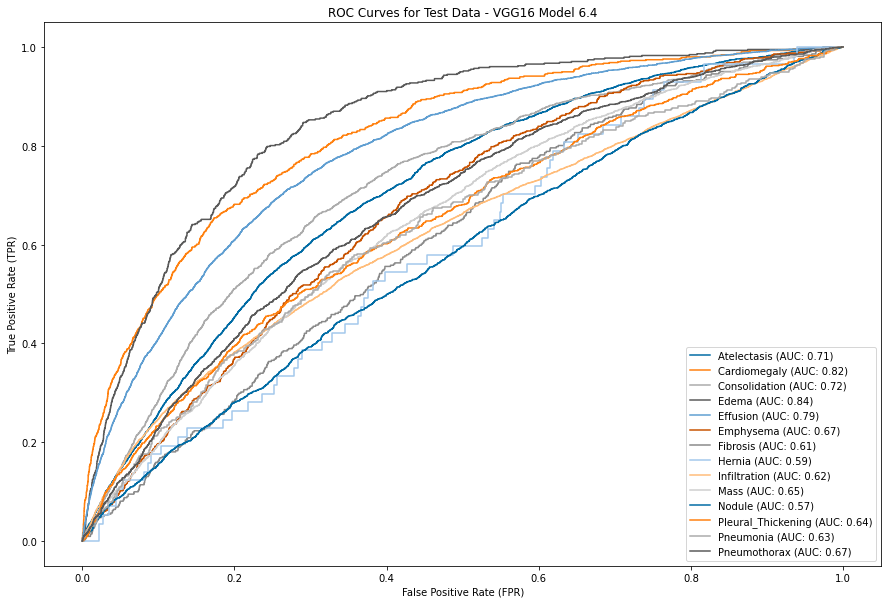

In [27]:
plot_roc_auc(y_pred_64, test_df, labels, model_name='VGG16 Model 6.4')

### Model 12: InceptionV3

In [ ]:
base_model_inception = InceptionV3(
    include_top=False,
    weights="imagenet",
    pooling="avg",
    input_shape=(256, 256, 3)
)

output_layer = Dense(len(labels), activation='sigmoid')(base_model_inception.output)
model_Inception = Model(base_model_inception.input, output_layer)

for layer in model_Inception.layers:
    layer.trainable = True
    
#model_Inception.summary()

In [29]:
model_Inception.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg)
)

In [30]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/Round4/InceptionV3-model-12.h5'

chkpt_12 = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [31]:
%%time
history_12 = model_Inception.fit(
    train_generator_12, 
    validation_data=valid_generator_12,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_12, early, reduce_lr]
)

Epoch 1/40


2022-02-05 13:42:24.595169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.1724

2022-02-05 13:46:59.219448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 2.38012, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round4/InceptionV3-model-12.h5
250/250 [==============================] - 342s 1s/step - loss: 1.1724 - val_loss: 2.3801 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 1.1020
Epoch 00002: val_loss improved from 2.38012 to 1.62525, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round4/InceptionV3-model-12.h5
250/250 [==============================] - 332s 1s/step - loss: 1.1020 - val_loss: 1.6253 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 1.0687
Epoch 00003: val_loss did not improve from 1.62525
250/250 [==============================] - 332s 1s/step - loss: 1.0687 - val_loss: 2.2600 - lr: 0.0010
Epoch 4/40
250/250 [==============================] - ETA: 0s - loss: 1.0477
Epoch 00004: val_loss did not improve from 1.62525
250/250 [==============================] - 333s 1s/step - los

In [32]:
y_pred_12 = model_Inception.predict(test_generator_12, batch_size=64, verbose=True)

2022-02-05 15:06:06.273690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 454s 1s/step


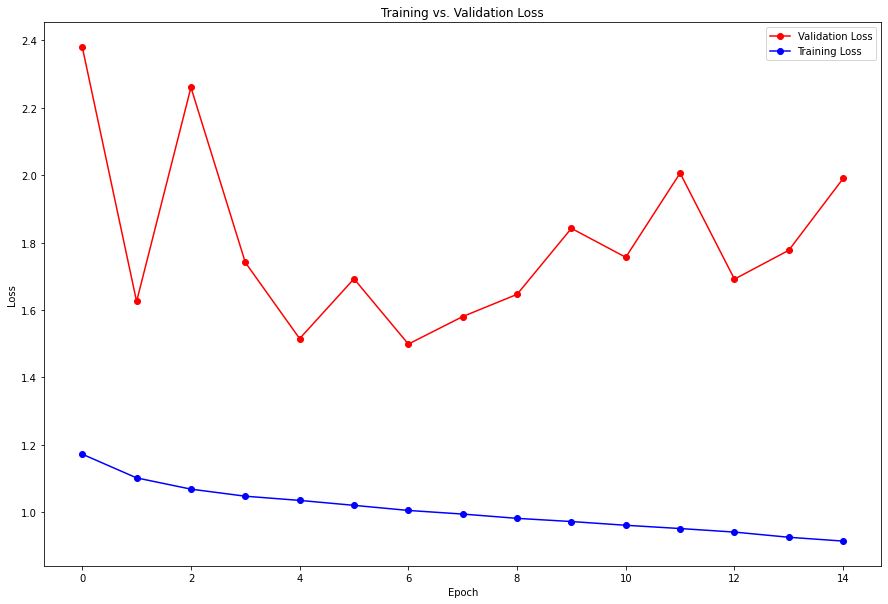

In [44]:
plot_losses(history_12)

AUC = 0.7384 for Atelectasis
AUC = 0.8485 for Cardiomegaly
AUC = 0.7320 for Consolidation
AUC = 0.8604 for Edema
AUC = 0.7907 for Effusion
AUC = 0.8184 for Emphysema
AUC = 0.7037 for Fibrosis
AUC = 0.8062 for Hernia
AUC = 0.6709 for Infiltration
AUC = 0.7761 for Mass
AUC = 0.7005 for Nodule
AUC = 0.6962 for Pleural_Thickening
AUC = 0.6144 for Pneumonia
AUC = 0.7165 for Pneumothorax


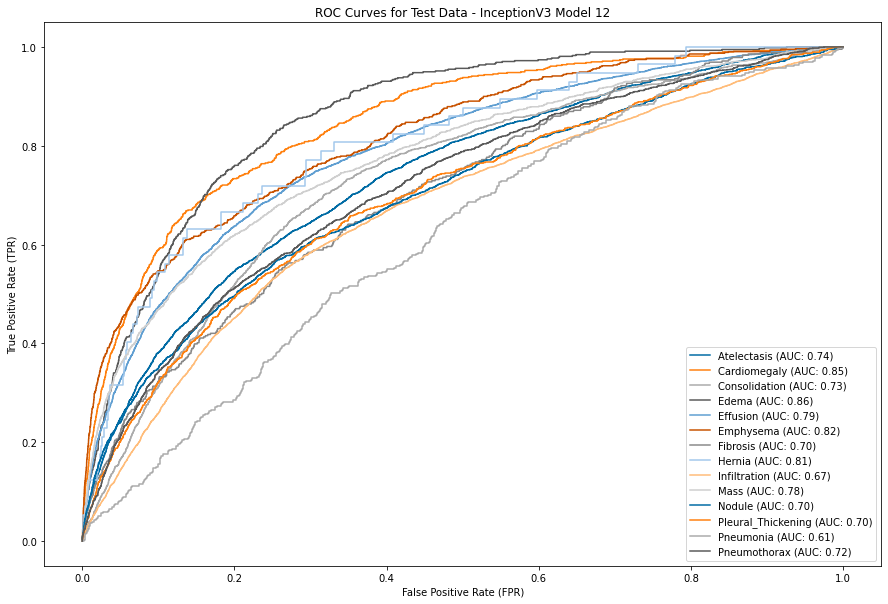

In [45]:
plot_roc_auc(y_pred_12, test_df, labels, model_name='InceptionV3 Model 12')

### Model 13.1: DenseNet169

In [ ]:
base_model_dn169 = DenseNet169(
    include_top=False,
    weights="imagenet",
    pooling="avg",
    input_shape=(256, 256, 3)
)

output_layer = Dense(len(labels), activation='sigmoid')(base_model_dn169.output)
model_dense169 = Model(base_model_dn169.input, output_layer)

for layer in model_dense169.layers:
    layer.trainable = True
    
#model_dense169.summary()

In [34]:
model_dense169.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg)
)

In [35]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/Round4/DenseNet169-model-13-1.h5'

chkpt_131 = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [36]:
%%time
history_131 = model_dense169.fit(
    train_generator_131, 
    validation_data=valid_generator_131,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_131, early, reduce_lr]
)

Epoch 1/40


2022-02-05 15:13:50.121124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.1726

2022-02-05 15:19:38.051912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 2.62348, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round4/DenseNet169-model-13-1.h5
250/250 [==============================] - 422s 2s/step - loss: 1.1726 - val_loss: 2.6235 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 1.1105
Epoch 00002: val_loss improved from 2.62348 to 1.91325, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round4/DenseNet169-model-13-1.h5
250/250 [==============================] - 408s 2s/step - loss: 1.1105 - val_loss: 1.9133 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 1.0842
Epoch 00003: val_loss improved from 1.91325 to 1.74086, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round4/DenseNet169-model-13-1.h5
250/250 [==============================] - 408s 2s/step - loss: 1.0842 - val_loss: 1.7409 - lr: 0.0010
Epoch 4/40
250/250 [==============================] - ETA: 0s - loss: 1.0626
Epoch 0

In [37]:
y_pred_131 = model_dense169.predict(test_generator_131, batch_size=64, verbose=True)

2022-02-05 17:02:31.769729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 473s 1s/step


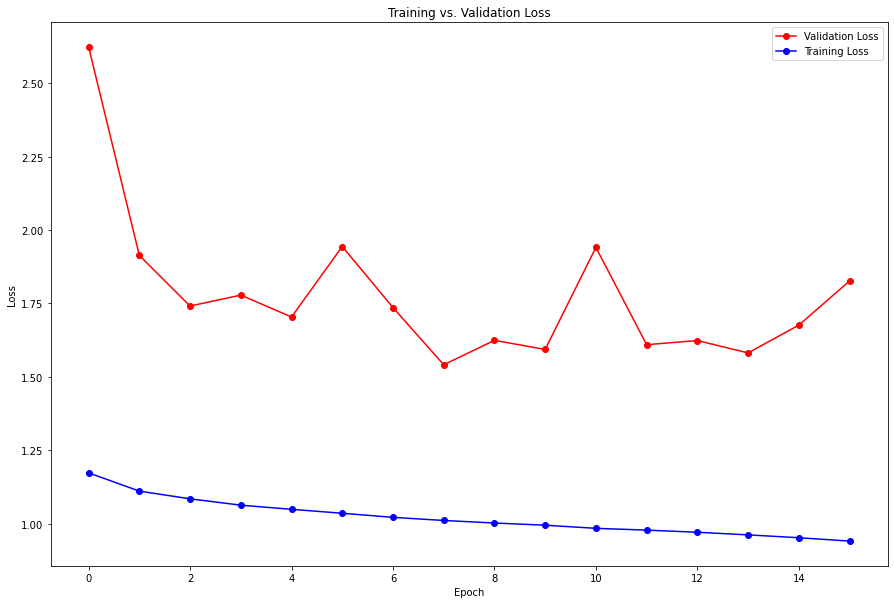

In [43]:
plot_losses(history_131)

AUC = 0.7806 for Atelectasis
AUC = 0.8406 for Cardiomegaly
AUC = 0.7584 for Consolidation
AUC = 0.8593 for Edema
AUC = 0.8423 for Effusion
AUC = 0.8525 for Emphysema
AUC = 0.7408 for Fibrosis
AUC = 0.8400 for Hernia
AUC = 0.6007 for Infiltration
AUC = 0.8009 for Mass
AUC = 0.6992 for Nodule
AUC = 0.7047 for Pleural_Thickening
AUC = 0.6148 for Pneumonia
AUC = 0.8165 for Pneumothorax


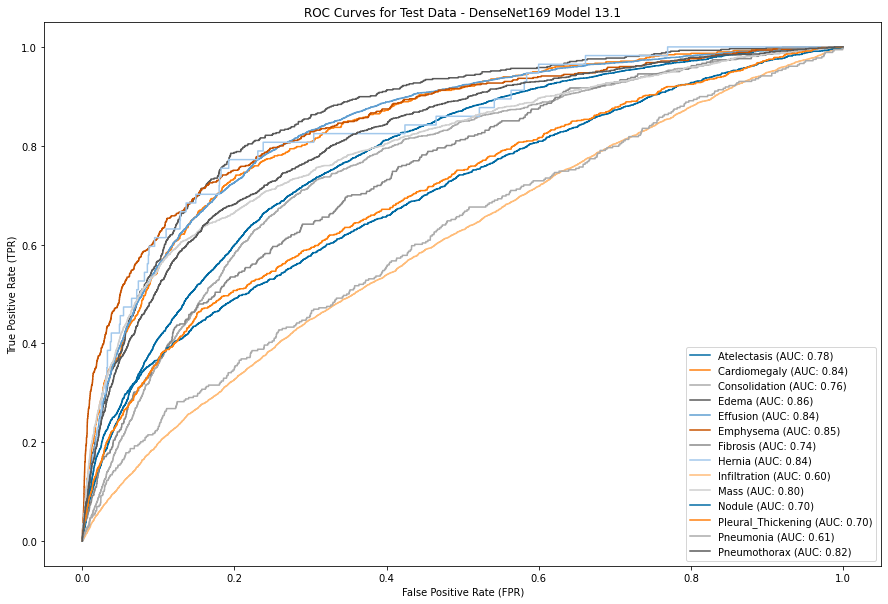

In [46]:
plot_roc_auc(y_pred_131, test_df, labels, model_name='DenseNet169 Model 13.1')

### Model 13.2: DenseNet201

In [ ]:
base_model_dn201 = DenseNet201(
    include_top=False,
    weights="imagenet",
    pooling="avg",
    input_shape=(256, 256, 3)
)

output_layer = Dense(len(labels), activation='sigmoid')(base_model_dn201.output)
model_dense201 = Model(base_model_dn201.input, output_layer)

for layer in model_dense201.layers:
    layer.trainable = True
    
#model_dense201.summary()

In [39]:
model_dense201.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg)
)

In [40]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/Round4/DenseNet201-model-13-2.h5'

chkpt_132 = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [41]:
%%time
history_132 = model_dense201.fit(
    train_generator_132, 
    validation_data=valid_generator_132,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_132, early, reduce_lr]
)

Epoch 1/40


2022-02-05 17:10:31.971214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.1791

2022-02-05 17:19:40.017388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 2.30516, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round4/DenseNet201-model-13-2.h5
250/250 [==============================] - 625s 2s/step - loss: 1.1791 - val_loss: 2.3052 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 1.1184
Epoch 00002: val_loss did not improve from 2.30516
250/250 [==============================] - 619s 2s/step - loss: 1.1184 - val_loss: 2.3364 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 1.0879
Epoch 00003: val_loss improved from 2.30516 to 2.05729, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round4/DenseNet201-model-13-2.h5
250/250 [==============================] - 618s 2s/step - loss: 1.0879 - val_loss: 2.0573 - lr: 0.0010
Epoch 4/40
250/250 [==============================] - ETA: 0s - loss: 1.0681
Epoch 00004: val_loss did not improve from 2.05729
250/250 [==============================] - 618s 2s/step -

In [42]:
y_pred_132 = model_dense201.predict(test_generator_132, batch_size=64, verbose=True)

2022-02-05 19:34:52.734778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 479s 1s/step


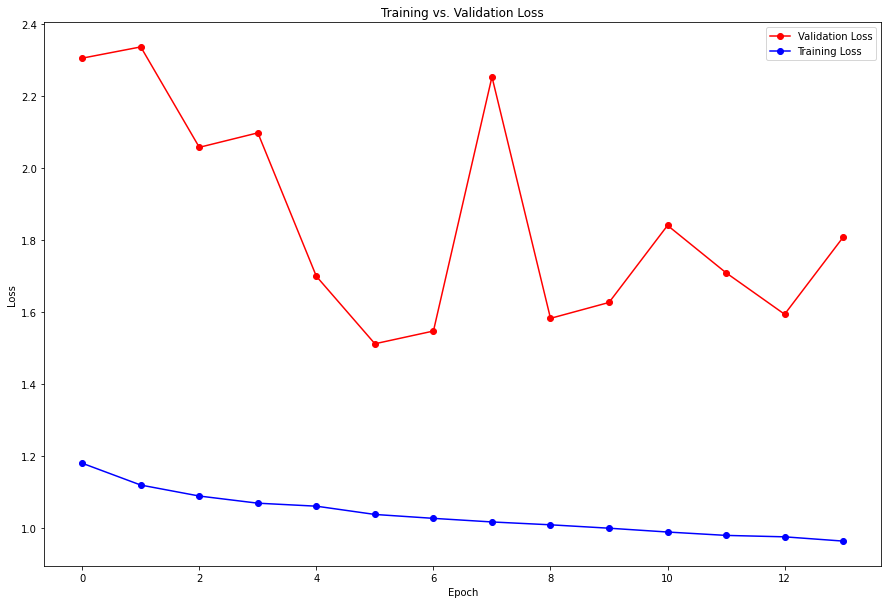

In [48]:
plot_losses(history_132)

AUC = 0.7782 for Atelectasis
AUC = 0.8731 for Cardiomegaly
AUC = 0.7228 for Consolidation
AUC = 0.8458 for Edema
AUC = 0.8458 for Effusion
AUC = 0.8305 for Emphysema
AUC = 0.7272 for Fibrosis
AUC = 0.8418 for Hernia
AUC = 0.6083 for Infiltration
AUC = 0.7751 for Mass
AUC = 0.6735 for Nodule
AUC = 0.6439 for Pleural_Thickening
AUC = 0.5543 for Pneumonia
AUC = 0.8042 for Pneumothorax


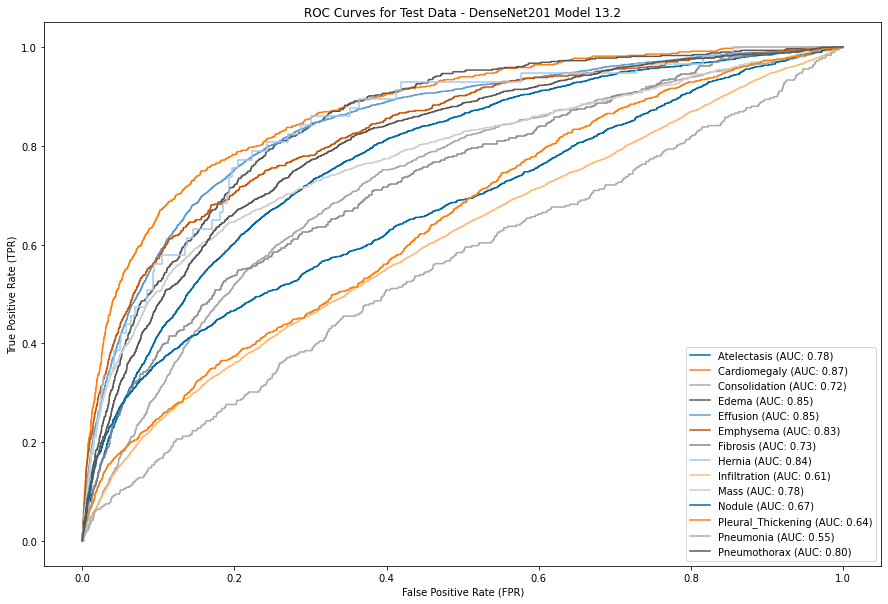

In [47]:
plot_roc_auc(y_pred_132, test_df, labels, model_name='DenseNet201 Model 13.2')